In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# モジュールのインポート
import os
import json
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
import pickle

In [3]:
# 自作モジュール
sys.path.append("../src")
import module_extraction
from module_extraction import Filters, Modules
import utils

分析対象の指定

In [4]:
# --オルソ画像 --
input_img_path = '../images/ortho/1391.tif'
#input_img_path = '../images/ortho/1477.tif'
#input_img_path = '../images/ortho/1466.tif'
#input_img_path = '../images/ortho/1480.tif'

#input_img_path = '../images/ortho/1411.tif'
#input_img_path = '../images/ortho/1481.tif'
#input_img_path = '../images/ortho/1441.tif'
#input_img_path = '../images/ortho/1473.tif'

In [5]:
# 出力先フォルダの作成
output_dir_path = "../outputs/"+input_img_path.split("/")[-1][:-4]
print(output_dir_path)
os.makedirs(output_dir_path,exist_ok=True)

../outputs/1391


フィルタの適用

In [6]:
filters = Filters()

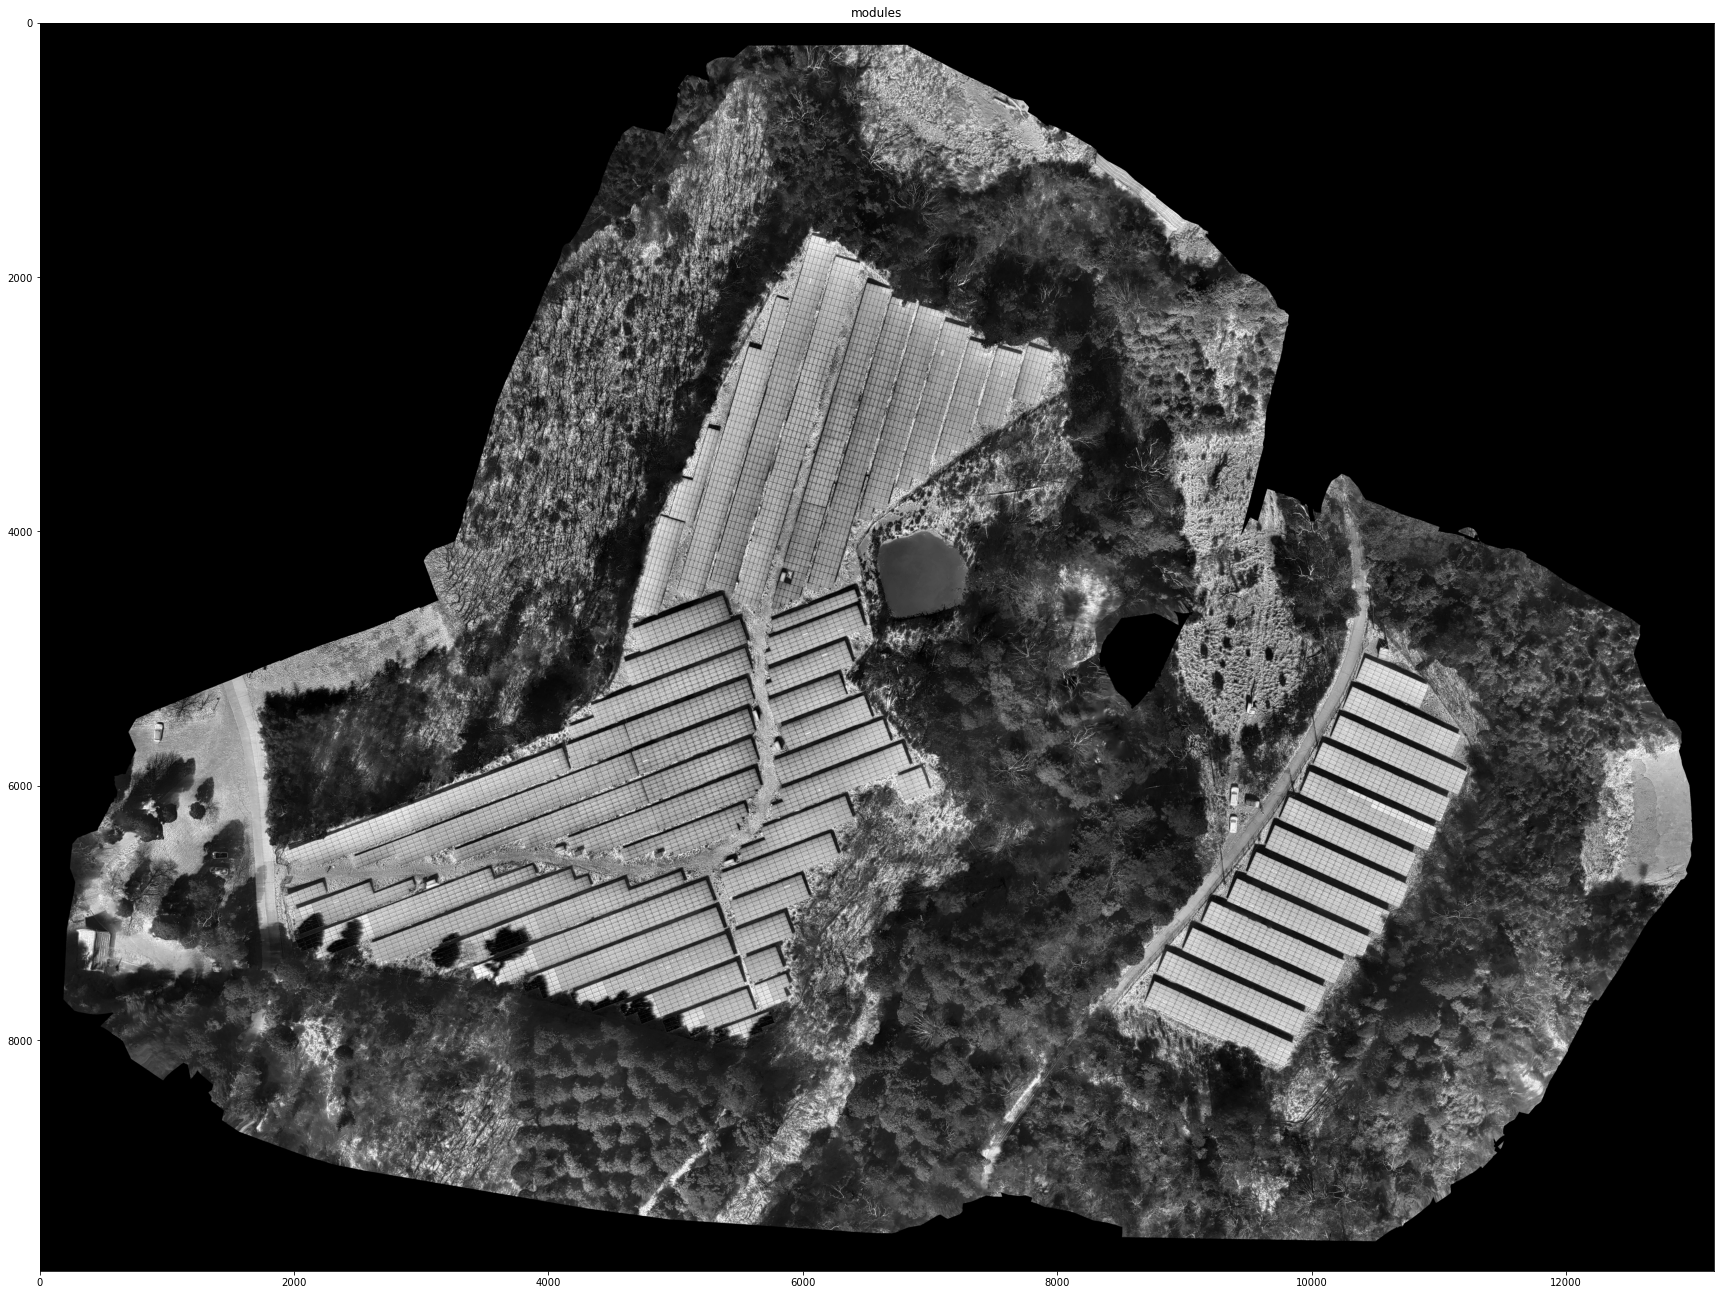

In [8]:
# 元画像
img_org = cv2.imread(input_img_path, 0)
utils.show_img({"modules":img_org},cmap="gray",figsize=(30,30))

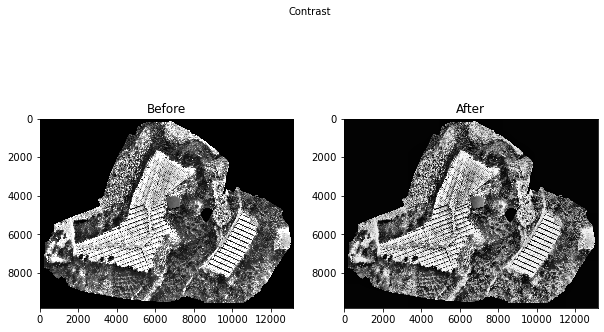

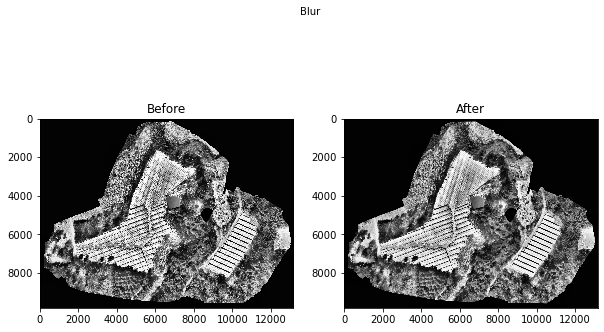

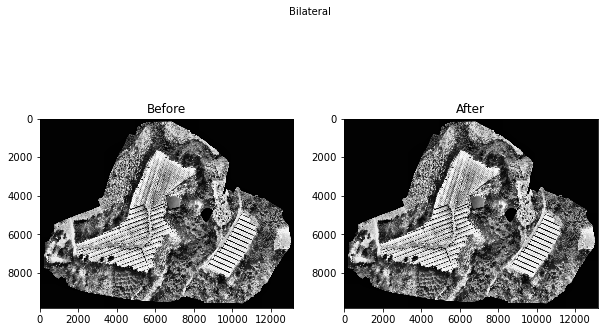

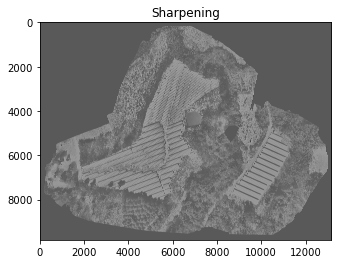

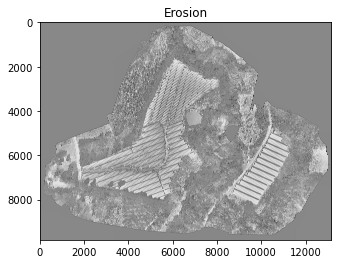

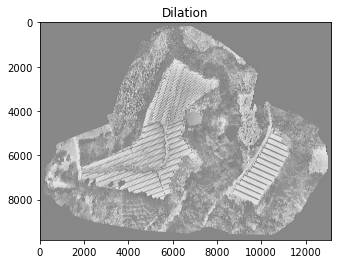

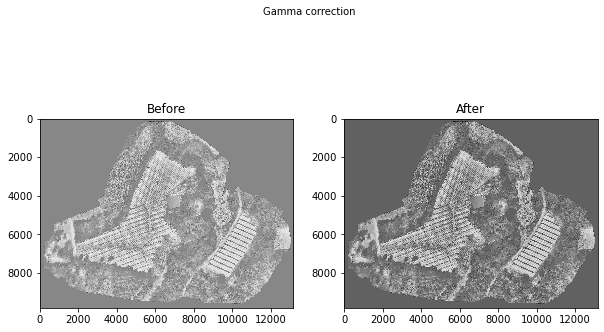

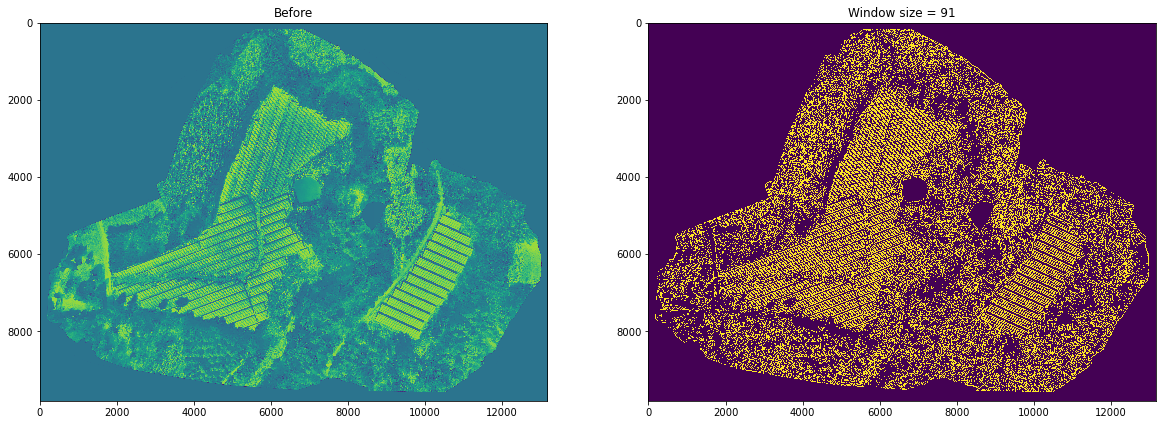

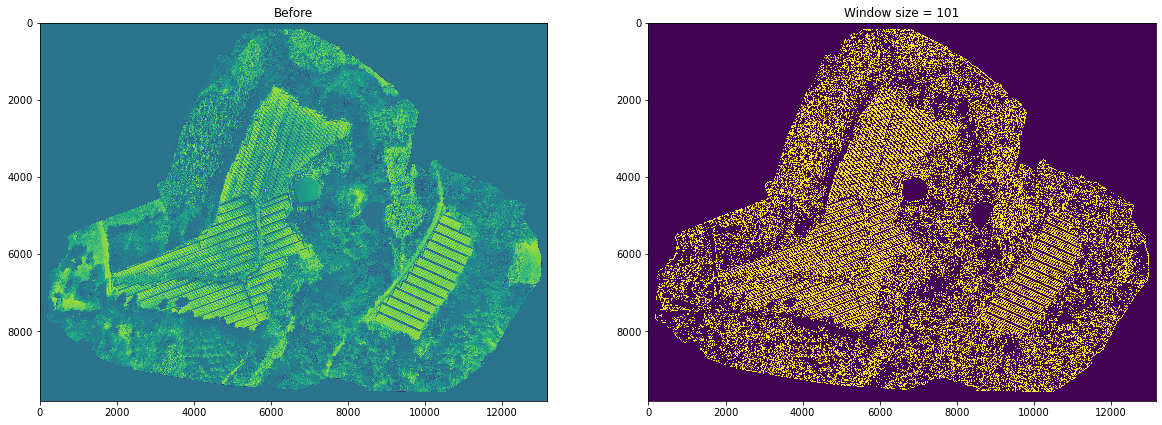

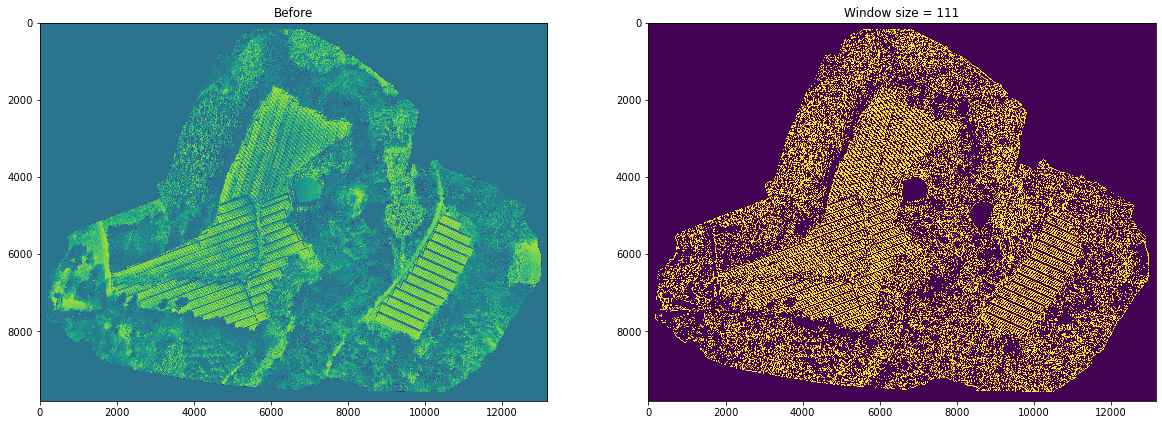

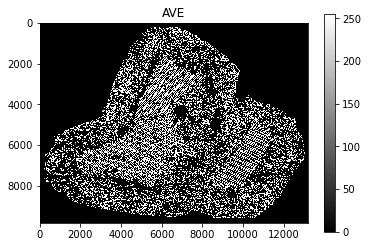

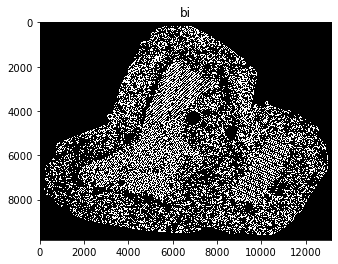

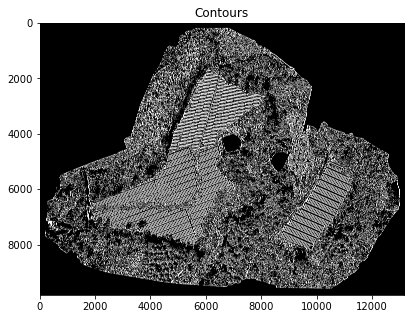

In [9]:
# 前処理
candidate_module_contours = filters.get_module_contours(img_org)

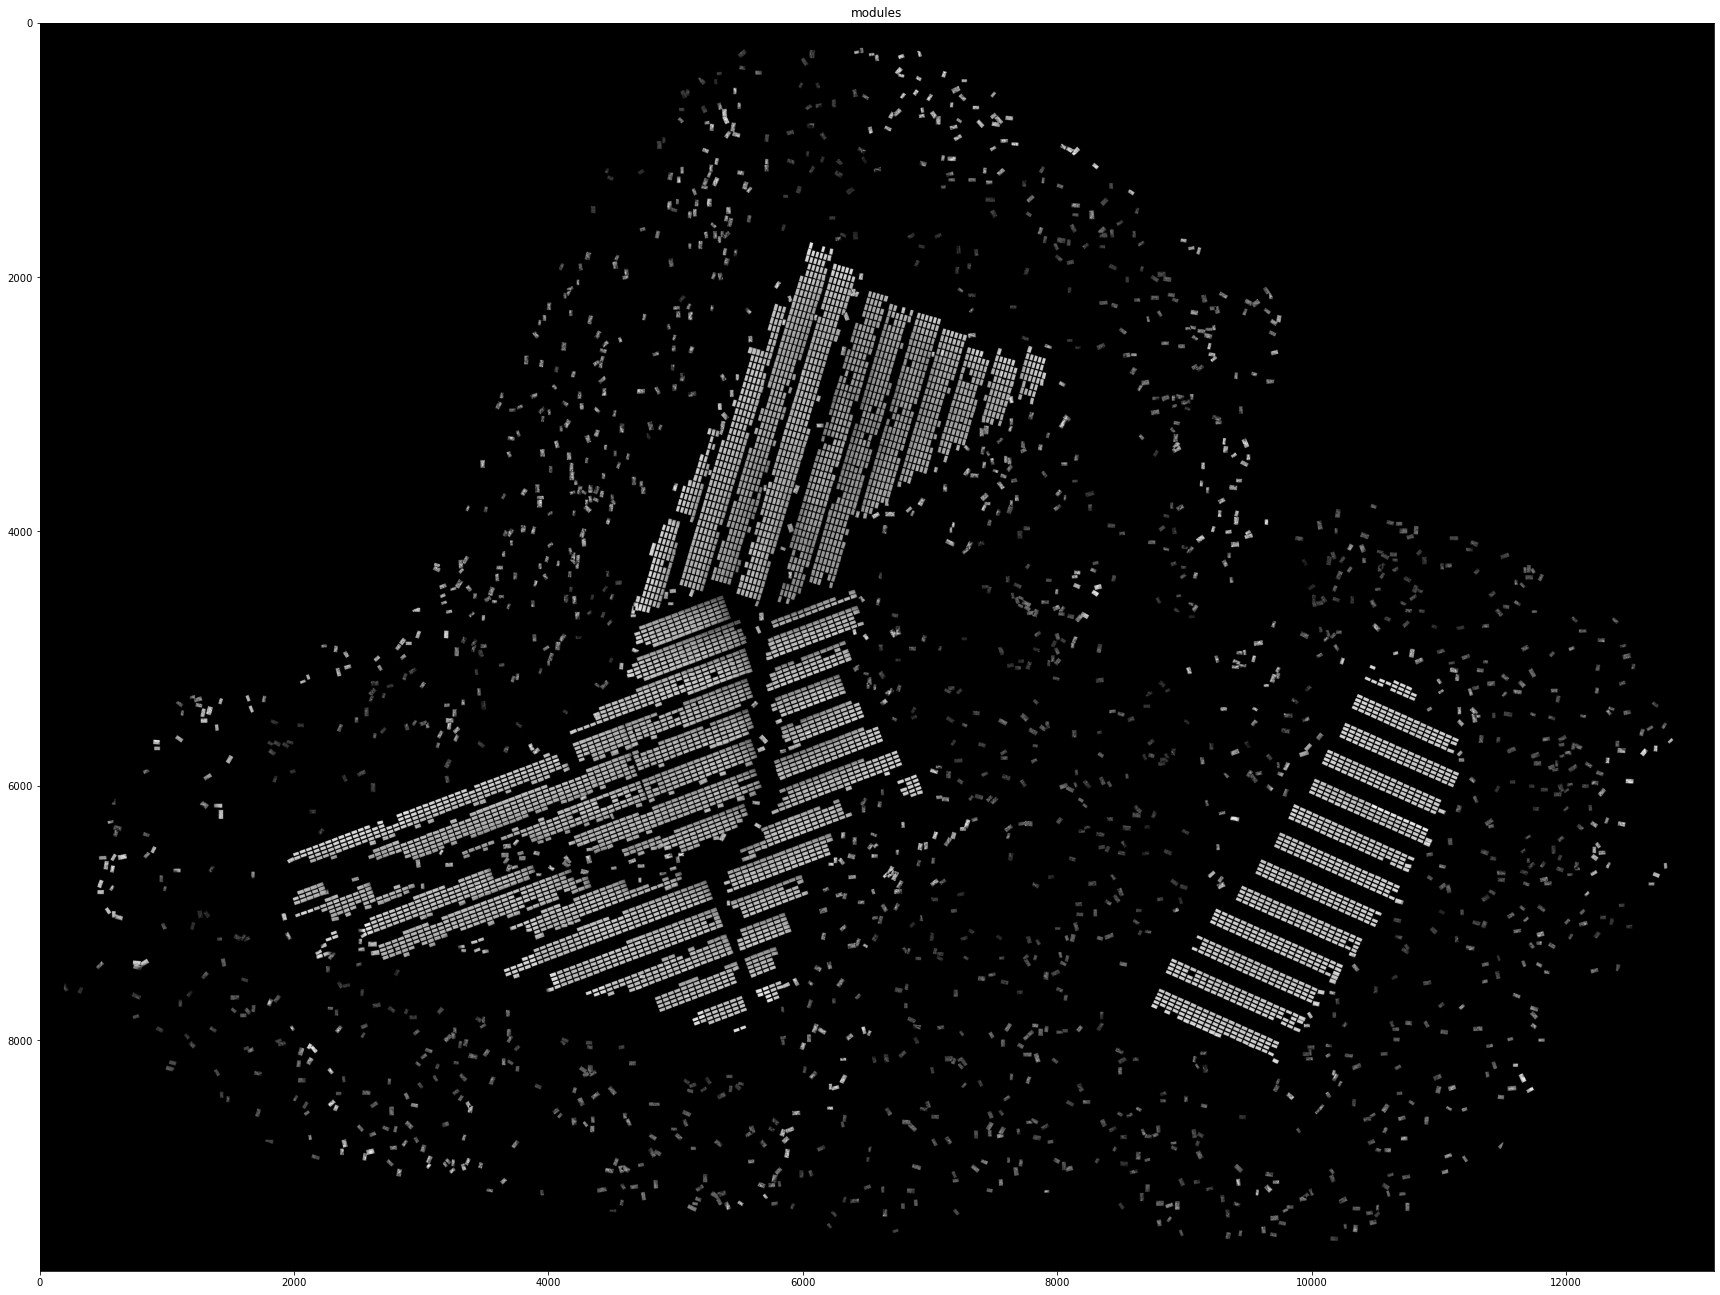

In [10]:
# モジュール抽出画像
img_con = cv2.drawContours(np.zeros_like(img_org), candidate_module_contours, -1, 255, -1)
img_mask = cv2.bitwise_and(img_org, img_con)
utils.show_img({"modules":img_mask},cmap="gray",figsize=(30,30))

In [11]:
# 画像の出力
img_write = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index_no_dbscan.png',img_write)

True

モジュール候補のクラスタリング

In [12]:
# クラスタのラベルを取得
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours, eps=1.25)

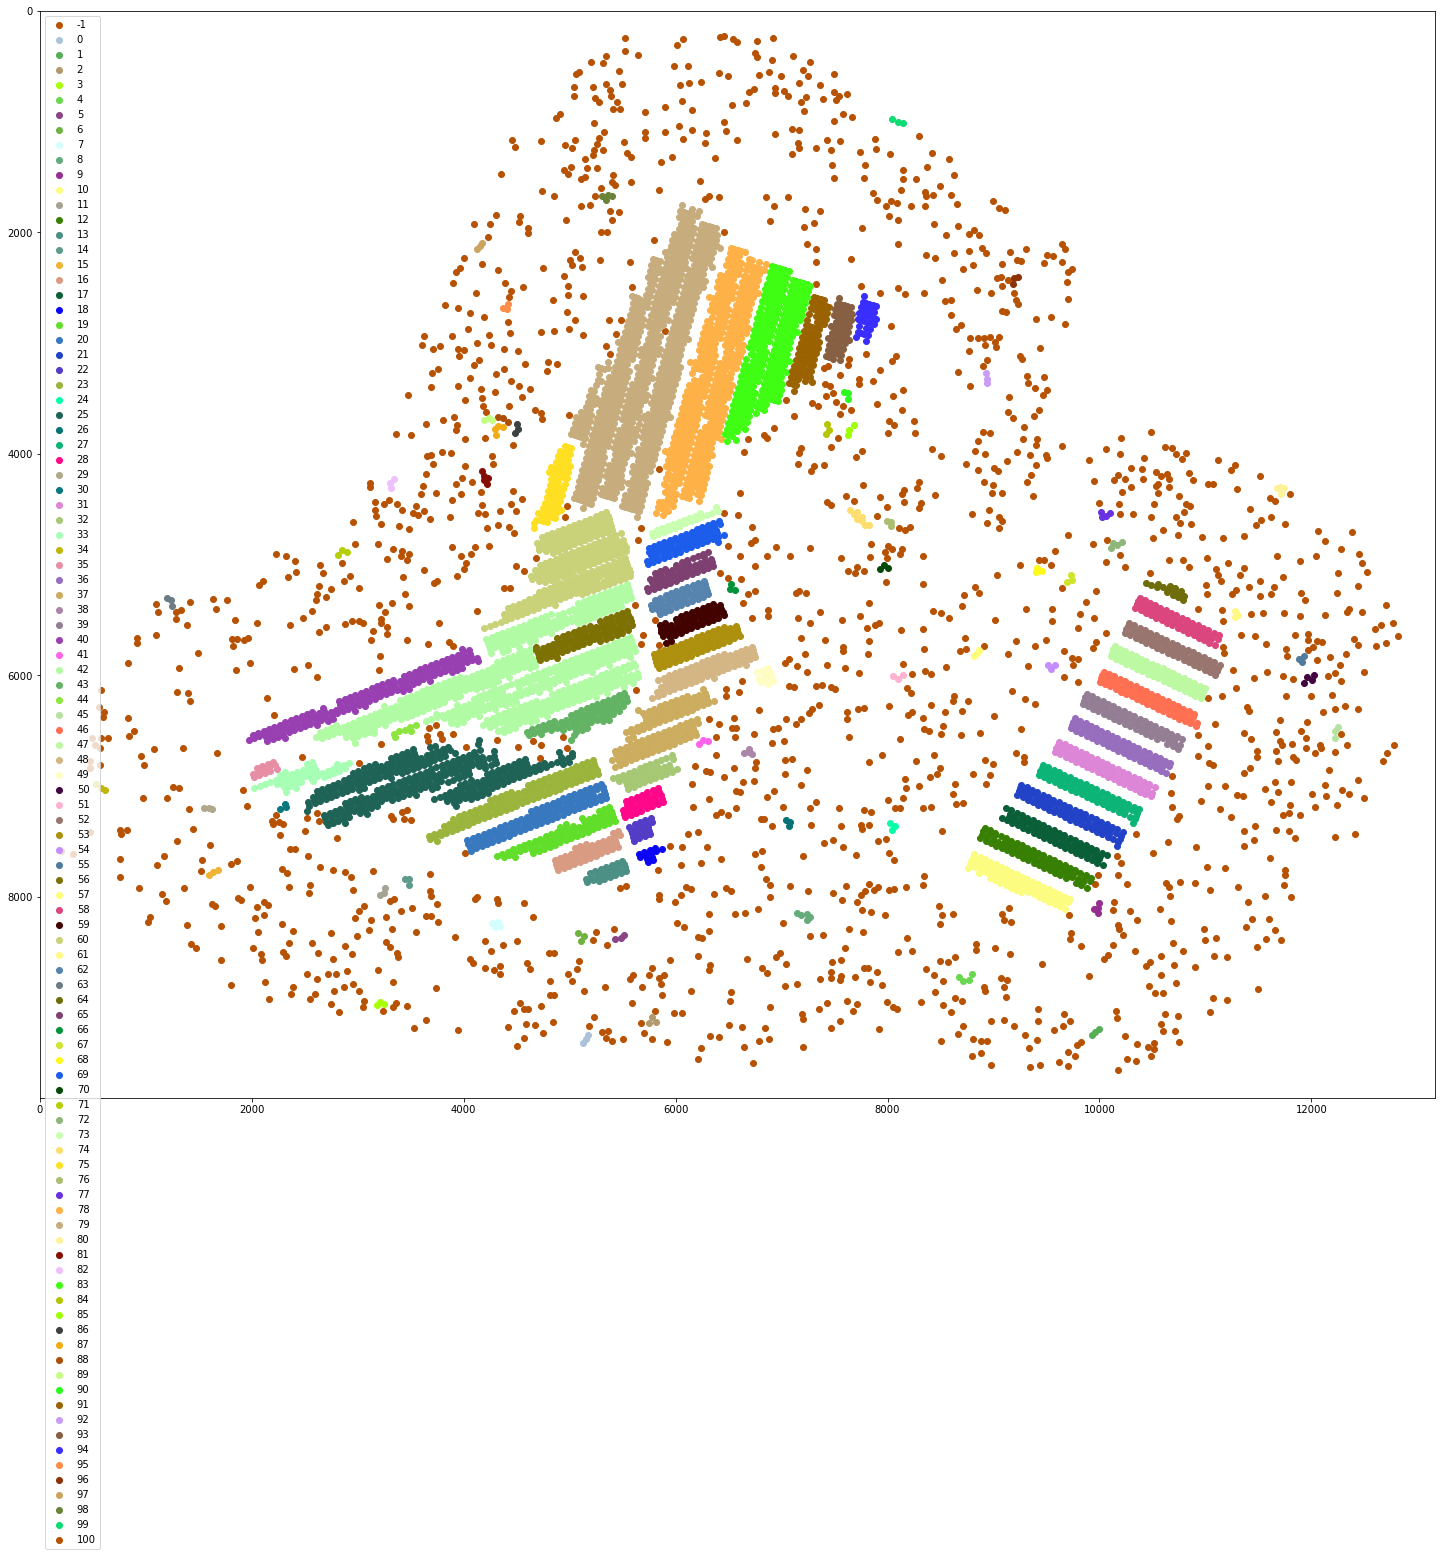

In [13]:
module_extraction.plot_module_map_with_labels(img_org, candidate_module_contours, module_labels)

サイズが大きいクラスタのみを残す

In [14]:
from collections import Counter
counter = Counter(module_labels)

In [15]:
counter.most_common

<bound method Counter.most_common of Counter({-1: 1653, 79: 820, 42: 671, 78: 473, 25: 371, 60: 306, 83: 298, 40: 170, 37: 148, 23: 139, 20: 117, 56: 93, 48: 89, 91: 86, 10: 84, 19: 81, 12: 80, 21: 80, 43: 80, 53: 78, 17: 76, 27: 76, 31: 75, 36: 75, 39: 74, 46: 74, 47: 72, 52: 72, 69: 71, 75: 70, 58: 63, 59: 59, 65: 57, 93: 55, 16: 54, 33: 52, 62: 52, 32: 49, 28: 38, 94: 32, 13: 29, 73: 24, 22: 22, 64: 16, 35: 14, 18: 13, 49: 13, 74: 8, 44: 7, 8: 5, 81: 5, 4: 4, 7: 4, 9: 4, 38: 4, 50: 4, 72: 4, 77: 4, 80: 4, 87: 4, 98: 4, 0: 3, 1: 3, 2: 3, 3: 3, 6: 3, 5: 3, 11: 3, 14: 3, 15: 3, 24: 3, 26: 3, 30: 3, 29: 3, 34: 3, 41: 3, 45: 3, 51: 3, 54: 3, 55: 3, 57: 3, 61: 3, 63: 3, 66: 3, 67: 3, 68: 3, 70: 3, 71: 3, 76: 3, 82: 3, 85: 3, 84: 3, 86: 3, 88: 3, 89: 3, 90: 3, 92: 3, 95: 3, 96: 3, 97: 3, 99: 3, 100: 3})>

In [16]:
n_threshold = 10
group_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>n_threshold ])
group_flags = [label in group_labels for label in module_labels]

サイズの大きいクラスタのみを残してクラスタリングを再実行

In [17]:
# クラスタのラベルを取得
module_contours = np.array(candidate_module_contours)[group_flags]
modules = Modules(module_contours) # 真のモジュール情報に更新
module_labels = modules.get_dbscan_labels(module_contours, eps=1.25)

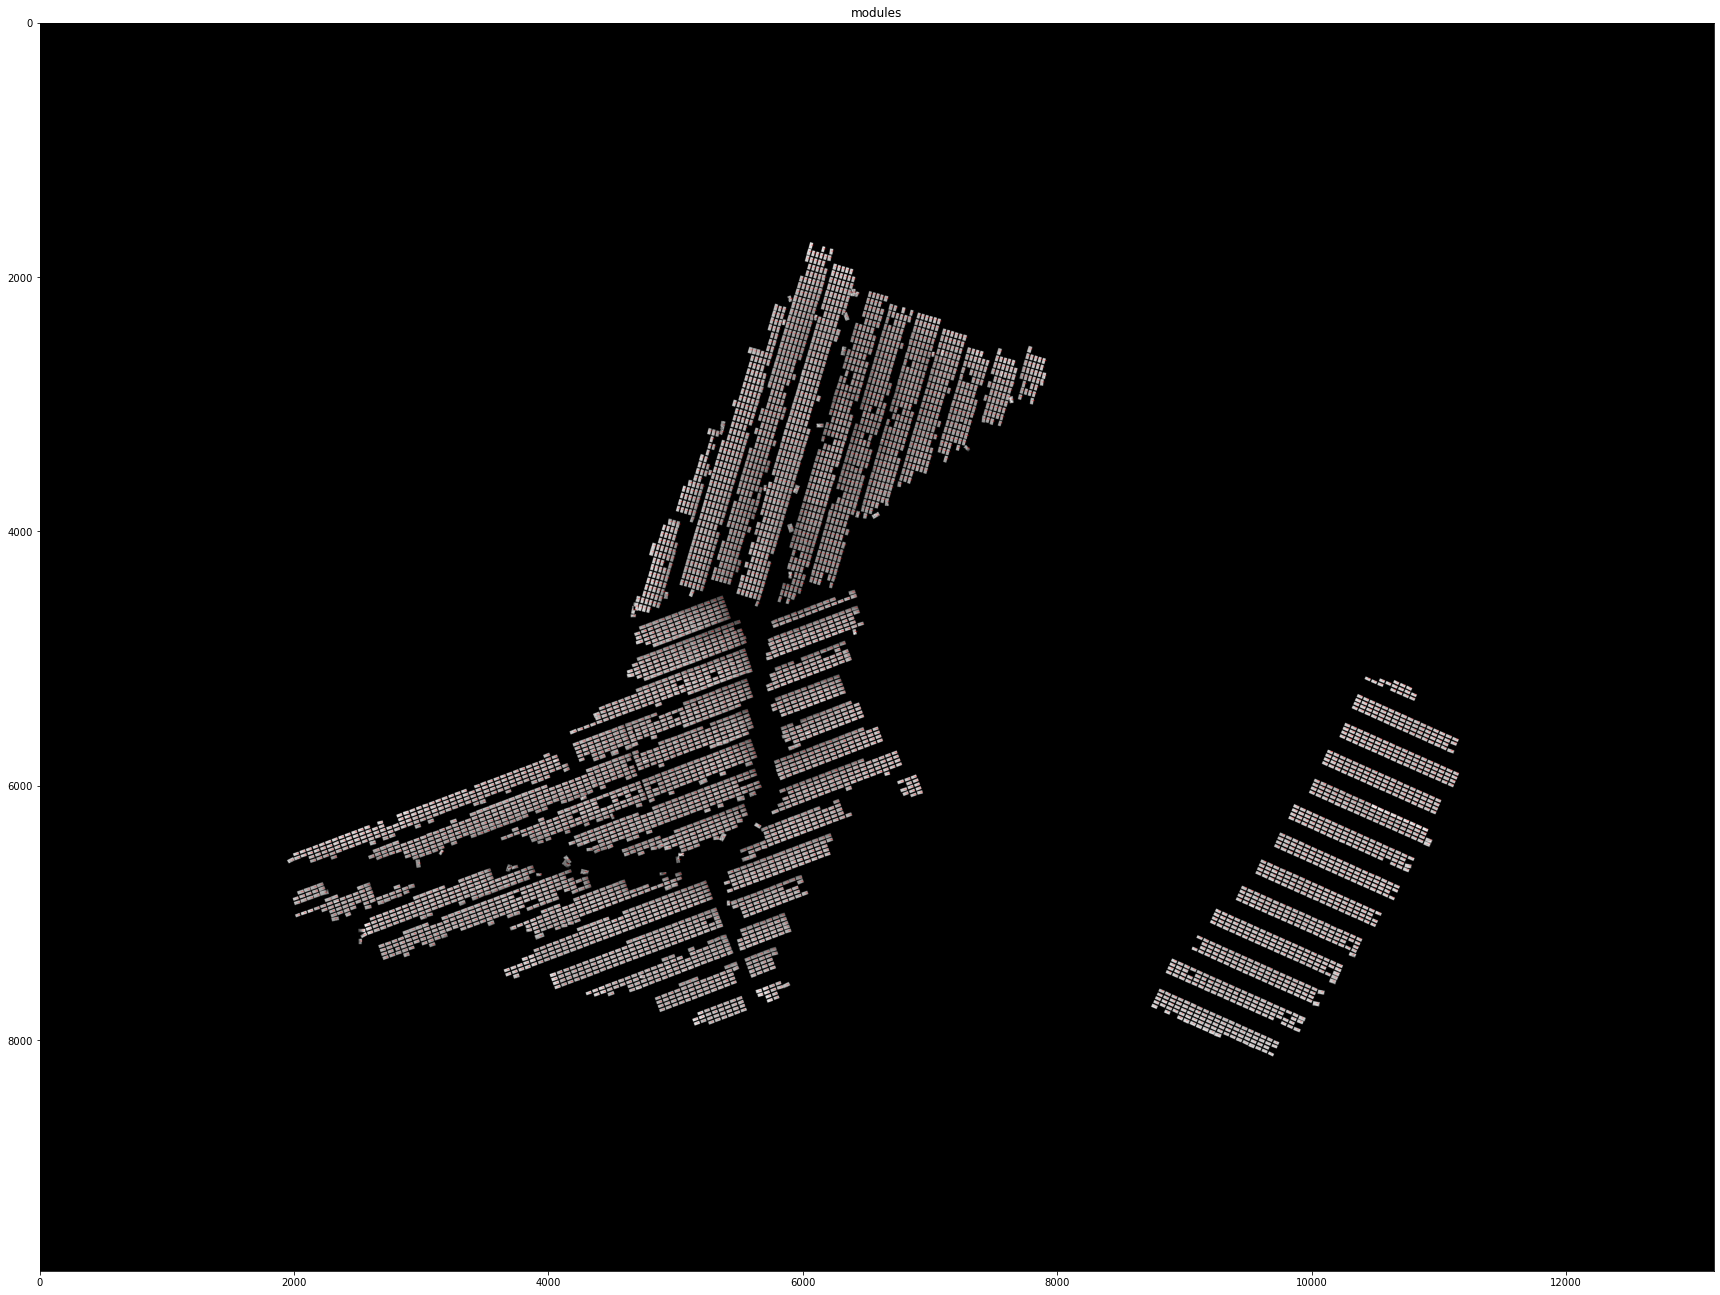

In [18]:
# モジュール抽出画像
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
utils.show_img({"modules":img_mask_index},cmap="gray",figsize=(30,30))

In [19]:
# 画像の出力
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

True

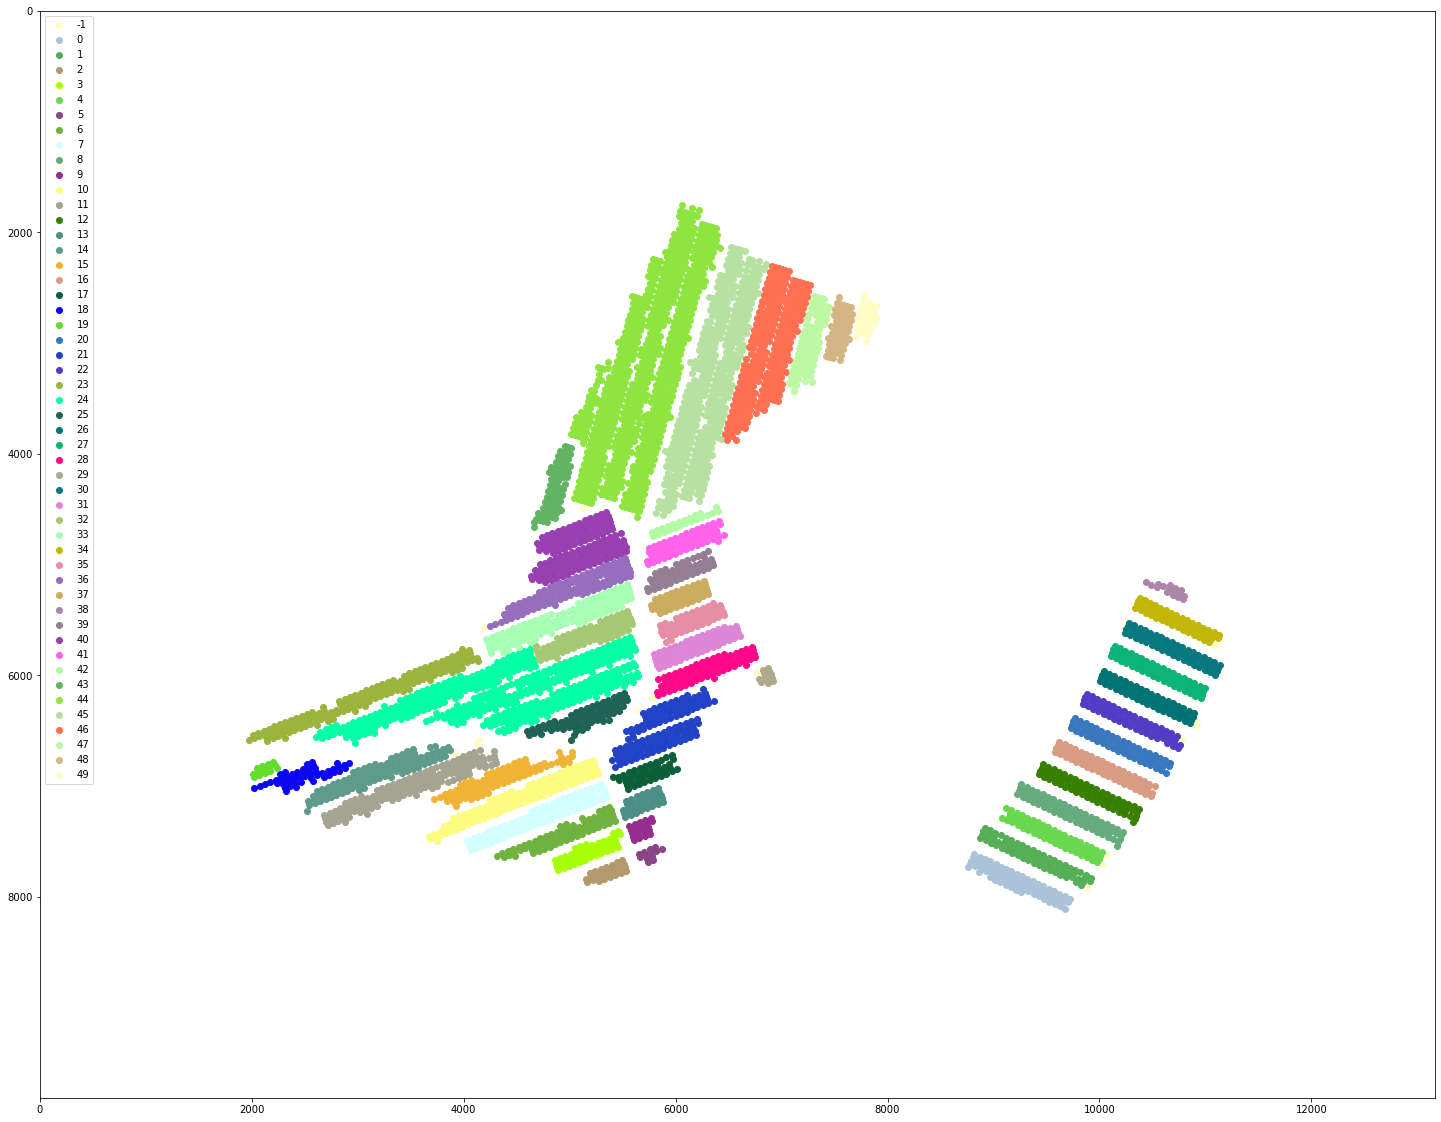

In [20]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, module_labels)

クラスタサイズ調整のための再分割

In [21]:
desired_cluster_size = 50

In [22]:
splitted_module_labels = module_extraction.split_module_labels(
    module_contours, module_labels, desired_cluster_size)

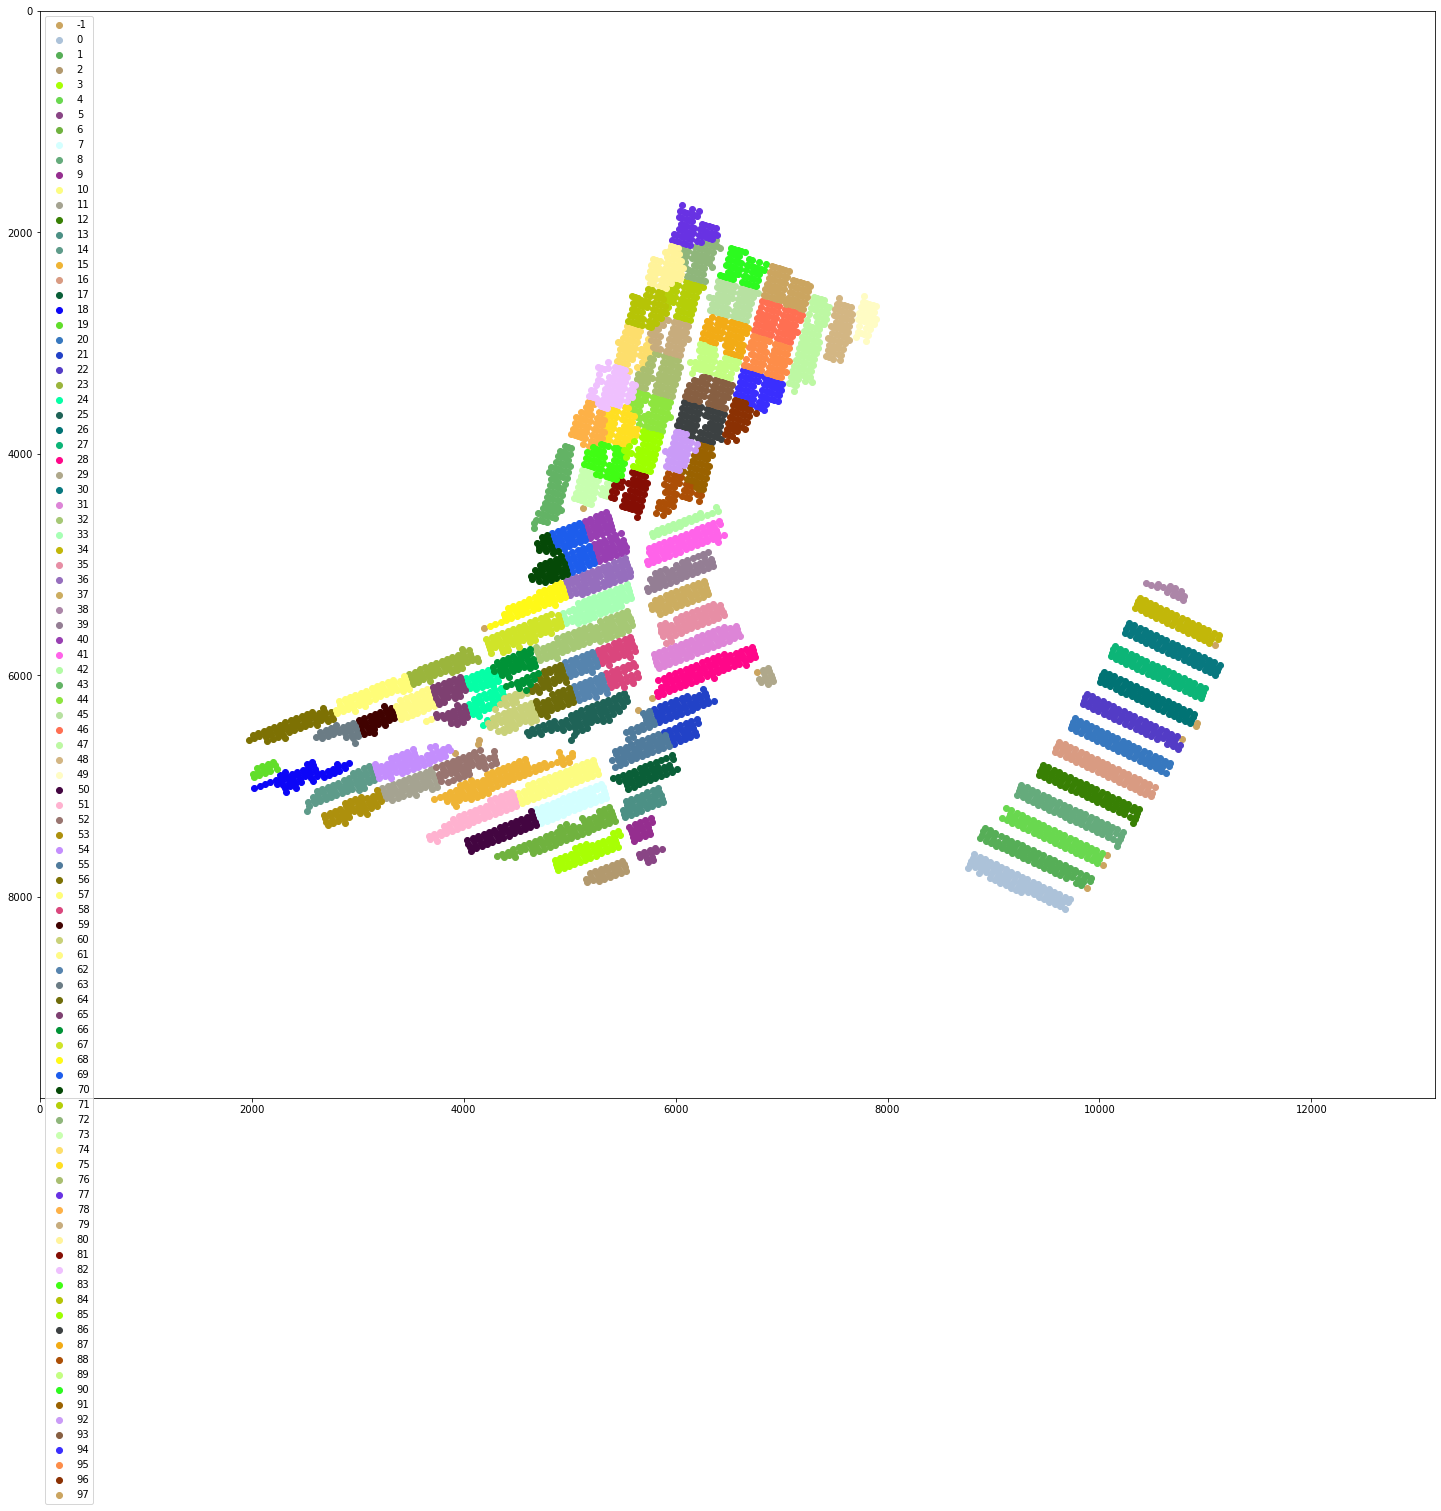

In [23]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, splitted_module_labels)

モジュールデータの保存

In [24]:
# モジュール画像の切り出し＆保存
modules.extract_modules(img_org, output_dir_path)

In [25]:
# モジュール輪郭情報とラベルの保存
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(module_labels, pkl)    
with open(output_dir_path+'/module_labels_split.pkl', 'wb') as pkl:
    pickle.dump(splitted_module_labels, pkl)    